In [1]:
#                            Package Import Section                            #
# ---------------------------------------------------------------------------- #
#region IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import traceback
import pandas as pd
# from surfalize import Surface

# Import the modules
import opd_read
import edge_detect
import laser_orientation
import flattening
import crown_extraction
import filters

# Import the importlib module
import importlib

# Reload the modules
importlib.reload(opd_read)
importlib.reload(edge_detect)
importlib.reload(laser_orientation)
importlib.reload(flattening)
importlib.reload(crown_extraction)
importlib.reload(filters)

# Re-import the functions
from opd_read import read_wyko_opd
from edge_detect import edge_detection
from laser_orientation import estimate_rotation_and_cs
from flattening import flatten
from crown_extraction import extract_crown_profiles
from filters import crown_delta_filter, crown_average_filter

#endregion
# Close all plots, clear data in workspace and records in Command Window.
plt.close('all')
# Clear all variables (not directly applicable in Python, but resetting relevant variables)
DATASETS = []

In [32]:
#                      USER INPUT / CONFIGURATION SECTION                      #
# ---------------------------------------------------------------------------- #
#region USER INPUTS

# ---------------- Input and Output Paths + Analysis Plot Names -------------- #
INPUTPATH = 'C:\\Users\\762093\\Documents\\WYKO_DATA'
OUTPUTPATH = 'C:\\Users\\762093\\Documents\\WYKO_DATA\\OUTPUTS\\output_debug'

CAMPAIGN_NAME = 'nxhpp_comparisons'


# ---------------------------- DATASETS to Analyse --------------------------- #
DATASETS = [
    # 'ASTRO_CUBE_1',
    'QDHIE_CUBE_161',
    # 'ASTRO_CUBE_3',
    # Add more DATASETS as needed
]
NUMDATA = len(DATASETS)


# ------- input the number of ROWS and columns in measured laser array. ------- #
ROWS = 3
COLS = 7
ROWRANGE = range(1, ROWS + 1)
COLRANGE = range(1, COLS + 1)


# -------------------------- Colours of Each Dataset ------------------------- #
COLORS = [[1, 0.5, 0], [0.5, 0, 0.5], [1, 0.5, 0], [0, 0, 1], [1, 0, 1]]


# Saved Images Quality (300 for decent runtime)
IMGQUAL = 300


# Contour Plot Z limit (range = 2*zlim, measured in nm)
ZLIM = 400


# Define Maps for edge and centre cubes
EDGE_POINTS = ['166', '167', '147', '148', '185', '128', '177', '157', '158', '138', '139', '120', '205', '195', '90', '81']
CENTRE_POINTS = ['161', '162', '163', '142', '143', '144', '123', '124', '136']

# ------------------------------ Filter Settings ----------------------------- #
# The "DELTA_THRESHOLD" will give the maximum allowed difference between adjacent 
# heights (in nm). If above this value, the code will filter out this data point
# as unphysical
# 
# The "ANOMALY_THRESHOLD" gives a similar maximum for a separate filter. This filter
# runs an average of 60 points surrounding each point, and if the target is 
# different above this set threshold, then it is filtered out as unphysical.
# This should be set higher than the "DELTA_THRESHOLD".
APPLY_DELTA_FILTER = True
APPLY_AVERAGE_FILTER = True

DELTA_THRESHOLD = 10  # Adjust this value as needed
ANOMALY_THRESHOLD = 25  # Adjust this value as needed
WINDOW_SIZE_INPUT = 20 # Adjust this value as needed


# --------------- Image Detection Parameters for Edge Detection -------------- #
EDGEDETECT = 3 # parameter for edge detect function. only change when needed.
LEFTEDGEWINDOW = [[200, 450], [120, 300]] # window for left edge detect, specify Y and X ranges respectively.


# ------- Option to group and color label plots based on 'design infos' ------ #
GROUP_BY_DESIGN_INFO = False  # Set to true to group by design infos, false to group by waferID and cubeID

DESIGN_INFOS = ['S1.7g',]  # Few Files Check

COLOURS_DESIGN_ORGANISED = [[0, 1, 1], [0.5, 0, 0.5], [1, 0.5, 0], [0.5, 0.5, 0], [1, 0, 1]]


# --------------------------- Different Array Sizes -------------------------- #
#  Set this to true if you want different array sizes within an analysis
#  batch. The sizes can be set in the row_dynamic and column_dynamic vectors
# . row_dynamic and column_dynamic ARE NOT USED IF THIS IS SET TO FALSE, ALL
# THE ARRAY SIZES ARE PRESUMED TO FOLLOW THE INITIAL "ROWS" and "columns"
# setting
DYNAMIC_ARRAYS = False

ROW_DYNAMIC = []

COLUMN_DYNAMIC = []


# ------------------------- Plotting Indexing Option: ROW  ------------------------- #
# NOTE that the for loop needs to edited (for each row, for each column)
# for this to be complete
PLOT_BY_COLUMN = True

#endregion USER INPUTS

In [3]:
#                    Preprocessing Steps and Initialisation                    #
# ---------------------------------------------------------------------------- #
#region Pre-Processing.

# Create output directory if it doesn't exist
os.makedirs(OUTPUTPATH, exist_ok=True)

# Check if the lengths of datasets and design_infos match
if len(DATASETS) != len(DESIGN_INFOS):
    if len(DESIGN_INFOS) < len(DATASETS):
        DESIGN_INFOS.extend(['unspecified'] * (len(DATASETS) - len(DESIGN_INFOS)))
    elif len(DESIGN_INFOS) > len(DATASETS):
        DESIGN_INFOS = DESIGN_INFOS[:len(DATASETS)]
# Verify lengths match after adjustment
if len(DATASETS) != len(DESIGN_INFOS):
    raise ValueError('Number of datasets not equal to number of design infos! Please make sure lengths match.')


# ---------------------- Initialize location_labels list --------------------- #
location_labels = []
# Determine edge or centre for each cubeID
for dataset in DATASETS:
    _, cubeID = dataset.split('_CUBE_')
    if cubeID in EDGE_POINTS:
        location_labels.append('Edge')
    elif cubeID in CENTRE_POINTS:
        location_labels.append('Centre')
    else:
        location_labels.append('Other')  # In case the cubeID is not found in either list
        
        
# ----------------------- Initialize laserIDranges list ---------------------- #
laserIDranges = []
# Loop through each dataset to calculate and store laserIDrange
for dataset in DATASETS:
    if DYNAMIC_ARRAYS:
        index = DATASETS.index(dataset)
        rows = ROW_DYNAMIC[index]
        cols = COLUMN_DYNAMIC[index]
        rowrange = range(1, rows + 1)
        colrange = range(1, cols + 1)
        laserIDranges.append(list(range(1, len(rowrange) * len(colrange) + 1)))
    else:
        # If DYNAMIC_ARRAYS is false, use a default range (adjust as needed)
        rowrange = range(1, ROWS + 1)
        colrange = range(1, COLS + 1)
        laserIDranges.append(list(range(1, len(rowrange) * len(colrange) + 1)))


# -------------------- Preallocate lists for data storage -------------------- #
data_raw = [None] * NUMDATA
data_processed = [None] * NUMDATA
data_crownprofiles = [None] * NUMDATA
data_xcrownprofiles = [None] * NUMDATA
data_crowns = [None] * NUMDATA
angle_matrix = [None] * NUMDATA
# Loop through each dataset to preallocate inner lists (FOR INCREASED PROCESSING SPEED)
for dataind in range(NUMDATA):
    laserIDrange = laserIDranges[dataind]
    # Preallocate inner lists
    data_raw[dataind] = [None] * len(laserIDrange)
    data_processed[dataind] = [None] * len(laserIDrange)
    data_crownprofiles[dataind] = [None] * len(laserIDrange)
    data_xcrownprofiles[dataind] = [None] * len(laserIDrange)
    data_crowns[dataind] = np.full((len(laserIDrange), 3), np.nan)  # Initialize with NaNs
    angle_matrix[dataind] = np.full((len(laserIDrange), 4), np.nan)  # Initialize with NaNs

processedMessages = []
#endregion Pre-Processing

In [4]:
#                       MAIN PROCESSING: Iterate Processing Loop over all input Data                       #
# ---------------------------------------------------------------------------- #
#region Iterative Loop
# Loop to read and process all opd files

# ITERATE FOR EACH DATASET
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    print(f"{waferID} CUBE {cubeID} is in processing.")
    
    # Define the input path for the current cube
    cubePath = os.path.join(INPUTPATH, dataset)
    
    # Detect the format of the .opd file
    test_files = [f for f in os.listdir(cubePath) if f.endswith('.fc.opd')]
    if not test_files:
        raise FileNotFoundError(f"No .opd files found in the directory: {cubePath}")
    
    # Read the first .opd file to determine the format
    test_file_name = test_files[0]
    if 'Row_' in test_file_name and '_Col_' in test_file_name:
        opdfilenameformat = 'Row_{0}_Col_{1}_'
    elif 'row' in test_file_name and 'column' in test_file_name:
        opdfilenameformat = 'row{0}column{1}'
    else:
        raise ValueError(f"Unknown .opd file format: {test_file_name}")
    
    #endregion Iterative Loop
    
    # ITERNATE FOR ALL LASERS PER DATASET
    # Iterate over all lasers per dataset using nested loops for rows and columns
    for rowID in ROWRANGE:
        for colID in COLRANGE:
            laserIDind = (rowID - 1) * COLS + (colID - 1)
            print(f"Processing Laser {laserIDind + 1}: Row {rowID}, Column {colID}")
            
            # ---------------------------------------------------------------------------- #
            #                              Reading .opd Files                              #
            # ---------------------------------------------------------------------------- #
            opdfilename = opdfilenameformat.format(rowID, colID)
            filename = os.path.join(cubePath, f"{opdfilename}.fc.opd")
                        
            try:
                # Reading .opd Files
                blocks, params, image_raw = read_wyko_opd(filename)
                last_valid_image_raw = image_raw
                
            except FileNotFoundError:
                if last_valid_image_raw is not None:
                    print(f"File missing: {filename}. Using the last valid image.")
                    image_raw = last_valid_image_raw
                else:
                    print(f"File missing: {filename}. No valid image found to copy from.")
                    continue
                       

            Resolution = float(params['Pixel_size']) * 1000
            
            # ---------------------------------------------------------------------------- #
            #                               Image Processing                               #
            # ---------------------------------------------------------------------------- #
            laser_edge, image_raw_positive = edge_detection(image_raw, EDGEDETECT)
            
            try:
                leftedge_angle, center_CS = estimate_rotation_and_cs(laser_edge, Resolution, LEFTEDGEWINDOW, image_raw)
            except Exception as e:
                print("An error occurred:", e)
                traceback.print_exc()
                continue
            
            # Plane Fitting
            data_processed_laser, theta_z_real, roll_angle, pitch_angle = flatten(image_raw_positive, Resolution, center_CS, leftedge_angle)
            yaw_angle = -leftedge_angle
            
            # Store raw and processed data
            data_raw[dataind][laserIDind] = image_raw
            data_processed[dataind][laserIDind] = data_processed_laser
            angle_matrix[dataind][laserIDind] = [theta_z_real, roll_angle, pitch_angle, yaw_angle]
            
            # ---------------------------------------------------------------------------- #
            #                           Crown Profile Extraction                           #
            # ---------------------------------------------------------------------------- #
            crown_profile, xcrown_profile = extract_crown_profiles(data_processed_laser, Resolution)
            
            # Apply filters to the crown and xcrown profiles
            if APPLY_DELTA_FILTER:
                crown_profile = crown_delta_filter(crown_profile, DELTA_THRESHOLD)
                xcrown_profile = crown_delta_filter(xcrown_profile, DELTA_THRESHOLD)
            if APPLY_AVERAGE_FILTER:
                crown_profile = crown_average_filter(crown_profile, window_size=WINDOW_SIZE_INPUT, threshold=ANOMALY_THRESHOLD)
                xcrown_profile = crown_average_filter(xcrown_profile, window_size=WINDOW_SIZE_INPUT, threshold=ANOMALY_THRESHOLD)
            
            # Calculate crown_values and xcrown values
            edgedistance = 0 # pixel numbers
            crown_value = 0 - 0.5 * (crown_profile[edgedistance, 1] + crown_profile[-edgedistance - 1, 1])
            xcrownP_value = 0 - xcrown_profile[edgedistance, 1]
            xcrownN_value = 0 - xcrown_profile[-edgedistance - 1, 1]
            
            # Store crown profiles and values
            data_crownprofiles[dataind][laserIDind] = crown_profile
            data_xcrownprofiles[dataind][laserIDind] = xcrown_profile
            data_crowns[dataind][laserIDind] = [crown_value, xcrownP_value, xcrownN_value]
            # print(f"Assigned to data_crowns[{dataind}][{laserIDind}]: YCrown = {crown_value}, XCrownP = {xcrownP_value}, XCrownN = {xcrownN_value}")
            
        

QDHIE CUBE 161 is in processing.
Processing Laser 1: Row 1, Column 1
Processing Laser 2: Row 1, Column 2
Processing Laser 3: Row 1, Column 3
Processing Laser 4: Row 1, Column 4
Processing Laser 5: Row 1, Column 5
Processing Laser 6: Row 1, Column 6
Processing Laser 7: Row 1, Column 7
Processing Laser 8: Row 2, Column 1
Processing Laser 9: Row 2, Column 2
Processing Laser 10: Row 2, Column 3
Processing Laser 11: Row 2, Column 4
Processing Laser 12: Row 2, Column 5
Processing Laser 13: Row 2, Column 6
Processing Laser 14: Row 2, Column 7
Processing Laser 15: Row 3, Column 1
Processing Laser 16: Row 3, Column 2
Processing Laser 17: Row 3, Column 3
Processing Laser 18: Row 3, Column 4
Processing Laser 19: Row 3, Column 5
Processing Laser 20: Row 3, Column 6
Processing Laser 21: Row 3, Column 7


In [5]:
#-------------------------- Print summary messages -------------------------- #
print("-------------------------- Data Processing is Completed! --------------------------")
print("Summary of all processed Datsets:")
for dataset in DATASETS:
    print(f"{dataset} has been processed.")
    
# -------------------------- Print crown values -------------------------- #
print("\nCrown values for each dataset:")
# print(data_crowns)
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    print(f"\n{waferID} CUBE {cubeID}:")
    for laserIDind, crown_values in enumerate(data_crowns[dataind]):
        ycrown, xcrownP, xcrownN = crown_values
        print(f"  Laser {laserIDind + 1}: YCrown = {ycrown:.2f} nm, XCrownP = {xcrownP:.2f} nm, XCrownN = {xcrownN:.2f} nm")

# ------------------------------- Print angles ------------------------------- #
print("\nAngles for each dataset:")
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    print(f"\n{waferID} CUBE {cubeID}:")
    for laserIDind, angles in enumerate(angle_matrix[dataind]):
        theta_z_real, roll_angle, pitch_angle, yaw_angle = angles
        print(f"  Laser {laserIDind + 1}: Roll = {roll_angle:.2f} degrees, Pitch = {pitch_angle:.2f} degrees, Yaw = {yaw_angle:.2f} degrees")

# # -------------------------- Print crown profiles -------------------------- #
# print("\nCrown profiles for each dataset:")
# for dataind, dataset in enumerate(DATASETS):
#     waferID, cubeID = dataset.split('_CUBE_')
#     print(f"\n{waferID} CUBE {cubeID}:")
#     for laserIDind, crown_profile in enumerate(data_crownprofiles[dataind]):
#         print(f"  Laser {laserIDind + 1} Crown Profile:")
#         for point in crown_profile:
#             print(f"    {point}")

-------------------------- Data Processing is Completed! --------------------------
Summary of all processed Datsets:
QDHIE_CUBE_161 has been processed.

Crown values for each dataset:

QDHIE CUBE 161:
  Laser 1: YCrown = -22.62 nm, XCrownP = 22.74 nm, XCrownN = 69.26 nm
  Laser 2: YCrown = -28.66 nm, XCrownP = 21.58 nm, XCrownN = 54.36 nm
  Laser 3: YCrown = -0.54 nm, XCrownP = 21.48 nm, XCrownN = 73.24 nm
  Laser 4: YCrown = -9.97 nm, XCrownP = 19.51 nm, XCrownN = 71.98 nm
  Laser 5: YCrown = -41.35 nm, XCrownP = 14.62 nm, XCrownN = 59.74 nm
  Laser 6: YCrown = -95.79 nm, XCrownP = 20.23 nm, XCrownN = 63.32 nm
  Laser 7: YCrown = -63.64 nm, XCrownP = 13.22 nm, XCrownN = 42.36 nm
  Laser 8: YCrown = -27.71 nm, XCrownP = 19.47 nm, XCrownN = 49.71 nm
  Laser 9: YCrown = 1.73 nm, XCrownP = 16.61 nm, XCrownN = 46.30 nm
  Laser 10: YCrown = -27.79 nm, XCrownP = 13.83 nm, XCrownN = 64.02 nm
  Laser 11: YCrown = 13.38 nm, XCrownP = 17.57 nm, XCrownN = 46.59 nm
  Laser 12: YCrown = -25.77 nm,

In [15]:
# ----------------------- Save statistics in excel file ---------------------- #

def save_data_to_excel(input_path, waferID, cubeID, laserIDrange, data_crowns, angle_matrix):
    # Create a list to hold the data
    crown_data = []
    for laserID in laserIDrange:
        laserID_index = laserID - 1
        crown_row = [
            laserID, 
            data_crowns[laserID_index][0], data_crowns[laserID_index][1], data_crowns[laserID_index][2],
            angle_matrix[laserID_index][0], angle_matrix[laserID_index][1], angle_matrix[laserID_index][2], angle_matrix[laserID_index][3]
        ]
        crown_data.append(crown_row)
    
    # Define column names
    columns = ['LaserID', 'YCrown', 'XCrown_P', 'XCrown_N', 'Theta_z', 'Roll', 'Pitch', 'Yaw']
    
    # Create a DataFrame
    df = pd.DataFrame(crown_data, columns=columns)
    
    # Define the output file name
    output_file = os.path.join(input_path, f"{waferID}_{cubeID}_data.xlsx")
    
    # Save the DataFrame to an Excel file
    df.to_excel(output_file, index=False)
    print(f"Data saved to {output_file}")

# Save data to Excel files for each waferID-cubeID pair
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    laserIDrange = laserIDranges[dataind]
    save_data_to_excel(INPUTPATH, waferID, cubeID, laserIDrange, data_crowns[dataind], angle_matrix[dataind])

Data saved to C:\Users\762093\Documents\WYKO_DATA\QDHIE_161_data.xlsx


In [42]:
# ----------------------- Generate Laser Plotting Order ---------------------- #
def generate_laser_plotting_order(laserIDranges, rows, cols, plot_by_column):
    laser_plotting_order = []
    for laserIDrange in laserIDranges:
        if plot_by_column:
            order = [col * rows + row for row in range(rows) for col in range(cols) if col * rows + row < len(laserIDrange)]
        else:
            order = list(range(len(laserIDrange)))
        laser_plotting_order.append(order)
    return laser_plotting_order

# Generate the laser plotting order
laser_plotting_order = generate_laser_plotting_order(laserIDranges, ROWS, COLS, PLOT_BY_COLUMN)
# print(laser_plotting_order)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


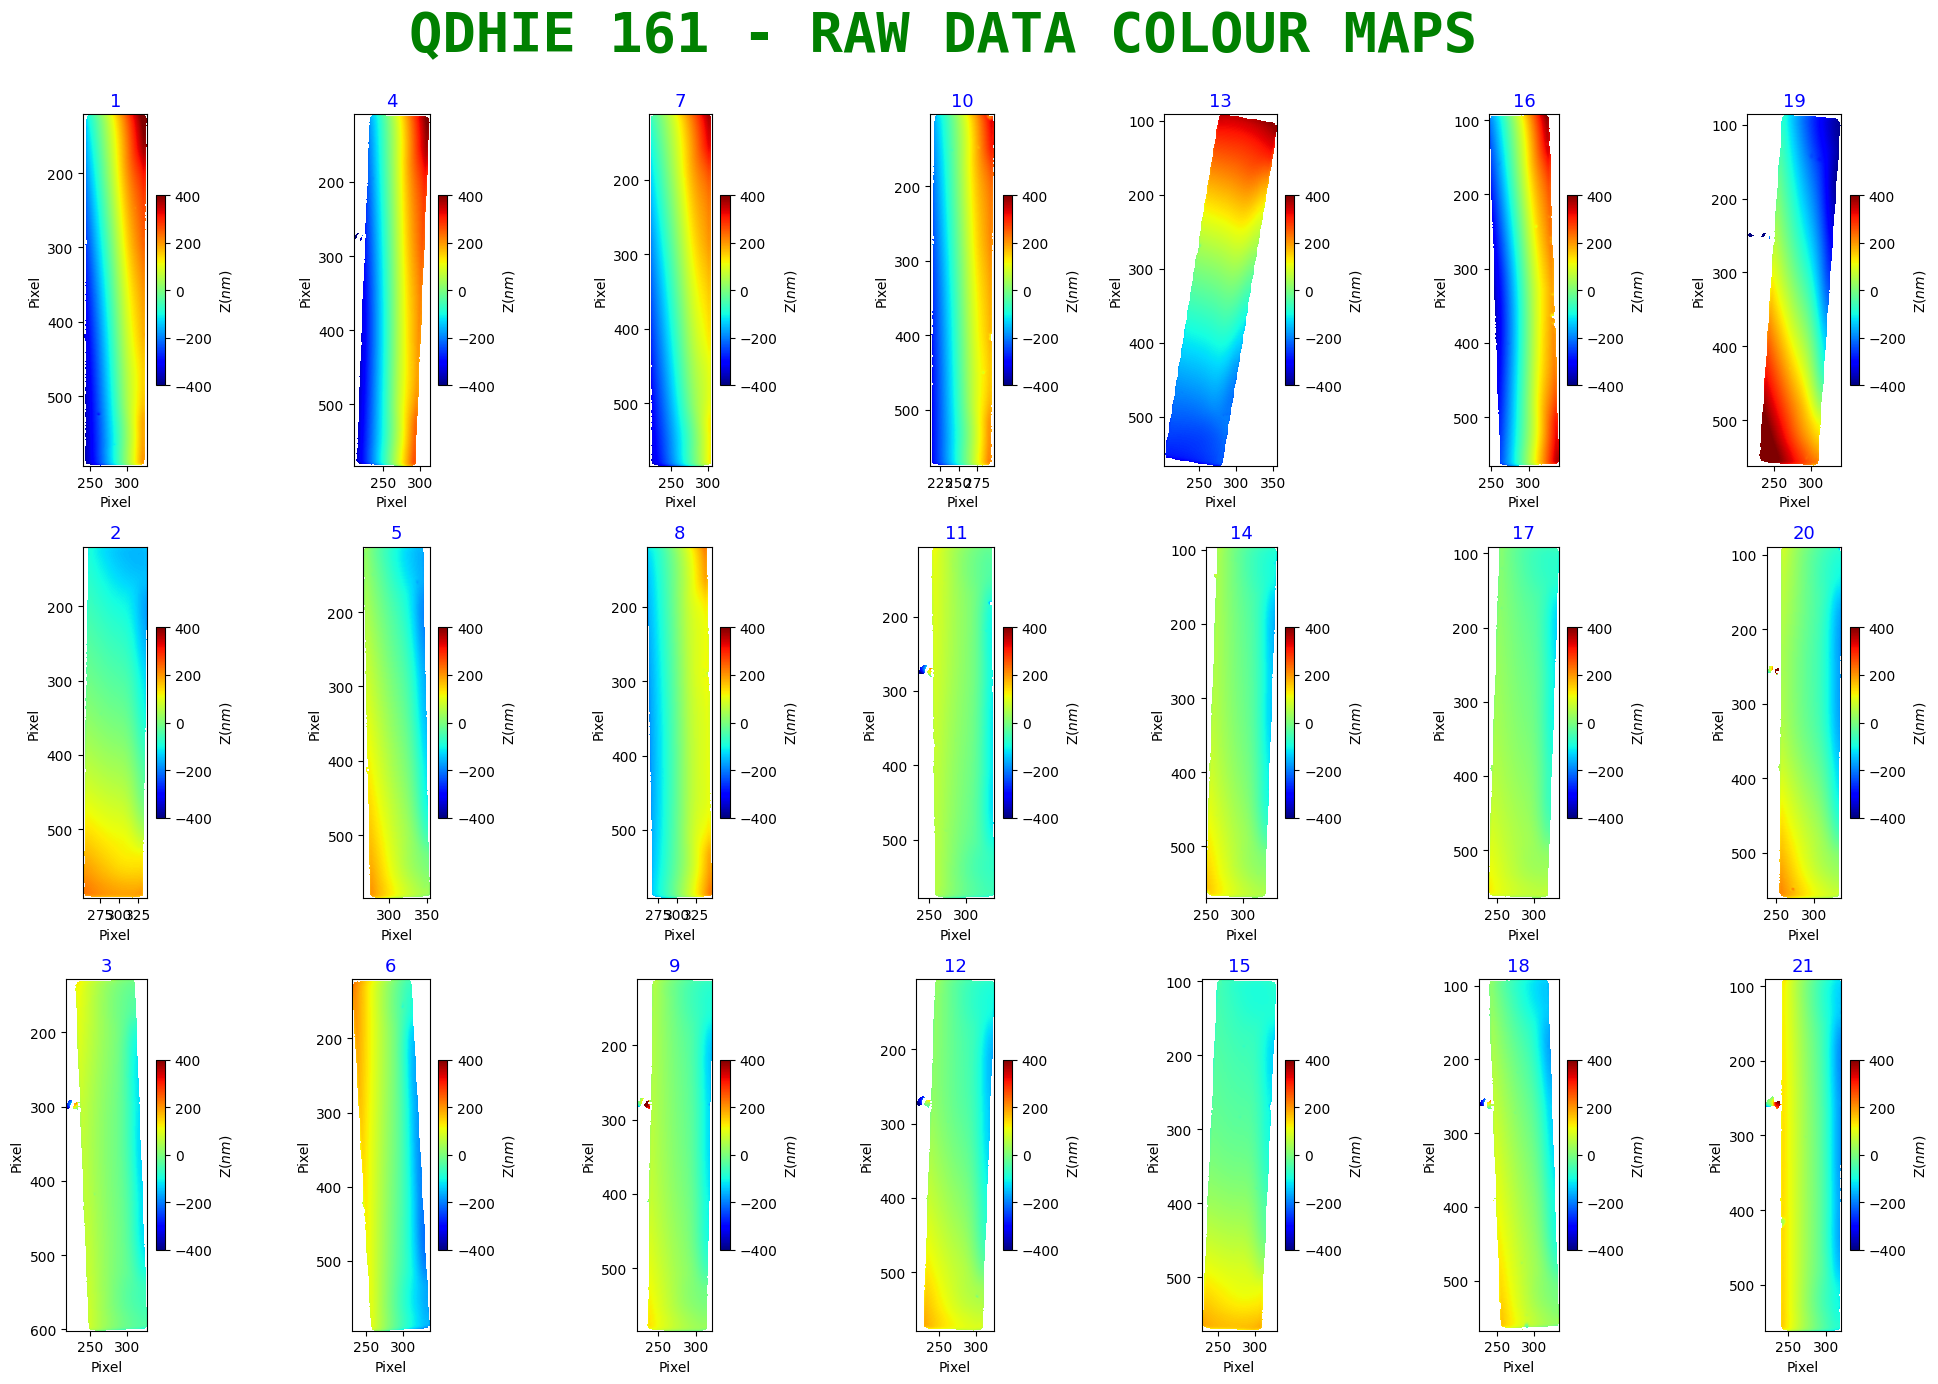

In [41]:
# --------------------------- RAW Colour Map Plots --------------------------- #
def plot_raw_data(data_raw, waferID, cubeID, laserIDrange, output_path, campaign_name, rows, cols, zlim_colour, imgqual, laser_plotting_order):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    fig.suptitle(f"{waferID} {cubeID} - RAW DATA COLOUR MAPS", fontsize=40, fontfamily='monospace', fontweight='bold', color='g', y=0.95)
    
    for plot_index in range(len(laserIDrange)):
        row = plot_index // cols
        col = plot_index % cols
        ax = axes[row, col]
        
        if plot_index < len(data_raw):
            image = data_raw[plot_index]
            im = ax.imshow(image, cmap='jet', aspect='equal')
            
            # Set the title based on the laser plotting order
            laserIDind = laser_plotting_order[plot_index]
            ax.set_title(f"{laserIDind + 1}", fontsize=13, color='b')
            
            ax.set_xlabel('Pixel')
            ax.set_ylabel('Pixel')
            im.set_clim([-zlim_colour, zlim_colour])
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
            cbar.set_label('Z$(nm)$', fontsize=10)
            
            # Set xlims and ylims to exclude empty spaces
            non_nan_indices = np.argwhere(~np.isnan(image))
            y_min, x_min = non_nan_indices.min(axis=0)
            y_max, x_max = non_nan_indices.max(axis=0)
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_max, y_min)  # Note: y-axis is inverted in images
        else:
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    output_file = os.path.join(output_path, f"{campaign_name}_{waferID}_{cubeID}_f1_Raw_Data.png")
    plt.savefig(output_file, dpi=imgqual)

# Plot raw data for each dataset
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    laserIDrange = laserIDranges[dataind]
    
    if DYNAMIC_ARRAYS:
        rows = ROW_DYNAMIC[dataind]
        cols = COLUMN_DYNAMIC[dataind]
    else:
        rows = ROWS
        cols = COLS
    
    plot_raw_data(data_raw[dataind], waferID, cubeID, laserIDrange, OUTPUTPATH, CAMPAIGN_NAME, rows, cols, ZLIM, IMGQUAL, laser_plotting_order[dataind])